# Investigating Gamma Scalping

Gamma scalping, or delta neutral trading, is trading strategy in which one trades around an option position. As such, the first thing we will need to implement is some measure of the price and Greeks of an option.

## Black Scholes Model

The ubiquitous options pricer is the Black-Scholes formula which is calculated as follows:

$$
\begin{align}
C &= N(d_1)S - N(d_2)Ke^{-rt} \\
P &= N(-d_2)Ke^{-rt} - N(-d_1)S\\
\\
d_1 &= \frac{\ln\left(\frac{S}{K}\right) + \left(r + \frac{\sigma^2}{2}\right)t}{\sigma\sqrt{t}}\\
\\
d_2 &= d_1 - \sigma\sqrt{t}
\end{align}
$$

Where: 

* $C=$ the price of a call option
* $P=$ the price of a put option
* $S=$ the price of the underlying asset
* $K=$ the strike price of the option
* $r=$ the risk-free rate
* $\sigma=$ the volatility of the asset (commonly calculated as the standard deviation of log returns)
* $t=$ the time until the option expires
* $N(\cdot)=$ the cumulative standard normal distribution

Let's now put this into code:

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
def BSM(option_type, S, K, r, sigma, t):
    
    d1 = (np.log(S/K) + (r+sigma**2/2)*t) / (sigma * np.sqrt(t))
    d2 = d1 - sigma*np.sqrt(t)
    
    if option_type == "c":
        return norm.cdf(d1)*S - norm.cdf(d2)*K*np.exp(-r*t)
    elif option_type == "p":
        return norm.cdf(-d2)*K*np.exp(-r*t) - norm.cdf(-d1)*S
    else:
        return "option_type can be 'c' or 'p'"

Let's now do a sanity check on the code by answering a question found in John Hull's Options, Futures, and Other Derivatives:

Calculate the price of a **3-month European put option** on a non-dividend-paying stock with a **strike price of \\$50** when the **current stock price is \\$50**, the **risk-free interest rate is 10% per annum**, and the **volatility is 30% per annum**.

In [3]:
S=50
K=50
r=0.1
sigma=0.3
t=3/12
option_type='p'

put_price = BSM(option_type, S, K, r, sigma, t)
put_price

2.3759406675006467

We can use put-call parity to validate the value of the corresponding call option:

In [4]:
implied_call_price = put_price + S - K *np.exp(-r*t)
implied_call_price

3.6104450660840115

In [5]:
option_type='c'

call_price = BSM(option_type, S, K, r, sigma, t)
call_price

3.610445066084015

## Option Delta

For this exercise, we will be looking at adjusting our position based on the option's **Delta** which is the derivative of BSM with respect to the underlying price. More intuitively, it is the sensitivity of the option price with respect to a change in the underlying price (all else constant). Very simply, the option's delta is calculated as:

$$
\begin{aligned}
\Delta(C) &= N(d_1)\\
\Delta(P) &= -N(-d_1)
\end{aligned}
$$

Now, let's put this into code:

In [6]:
def delta(option_type, S, K, r, sigma, t):
    
    d1 = (np.log(S/K) + (r+sigma**2/2)*t) / (sigma * np.sqrt(t))
    
    if option_type == "c":
        return norm.cdf(d1)
    
    elif option_type == "p":
        return -norm.cdf(-d1)
    
    else:
        return "option_type can be 'c' or 'p'"

As a sanity check, let's see what happens to the delta of an option as $S$ increases and decreases for both a call and a put:

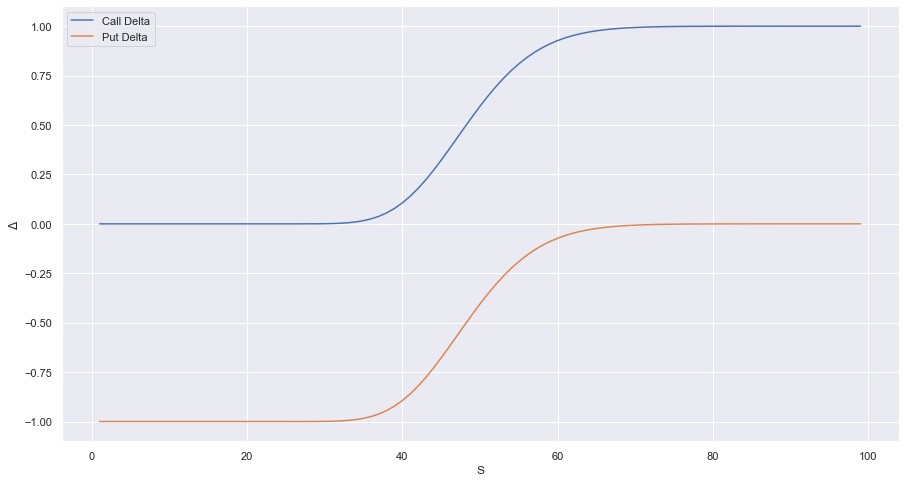

In [7]:
S_list = list(range(1,100))
call_delta_list = []
put_delta_list = []

for S in S_list:
    call_delta_list.append(delta('c', S, K, r, sigma, t))
    put_delta_list.append(delta('p', S, K, r, sigma, t))
    
delta_result = pd.DataFrame([S_list, call_delta_list, put_delta_list],index=["S","Call Delta","Put Delta"]).T.set_index("S")


plt.figure(figsize=(15,8))
plt.plot(delta_result,label=delta_result.columns)
plt.xlabel("S")
plt.ylabel("$\Delta$")
plt.legend()
plt.show()

Behaving exactly as we want it to.

## Delta Hedging

Delta hedging is the process of offsetting the gains/losses of an option by taking the opposite position in the underlying asset. More concretely, consider the options we've been working with above. Let's take the example where $S=K=50$. Then the delta of the call is:

In [8]:
S=50
delta('c', S, K, r, sigma, t)

0.5954807699023611

One might be surprised that it does not equal the heuristic 0.5, and to explain this, let's revisit the calculation of delta:

$$
\begin{alignat*}{3}
&               &\quad   \Delta(C) &= N(d_1)\\
&   \implies    &\quad   N(d_1) &= 0.5\\
&   \implies    &\quad   d_1 &= 0\\
&   \implies    &\quad   \frac{\ln\left(\frac{S}{K}\right) + \left(r + \frac{\sigma^2}{2}\right)t}{\sigma\sqrt{t}} &= 0\\
\end{alignat*}
$$

Which is true for the first term in the fraction, but $r$, $\sigma$, and $t$ are all $>0$ and so this does not hold up. Thus, we get a delta that is not equal to 0.5.

Coming back to delta hedging, the result 0.5954... indicates that for a marginal change in the underlying, one would expect the options price to move by approximately that amount. Let's test this theory:

In [9]:
epsilon_list = [10**-x for x in range(-1,8)]
delta_list = []

for epsilon in epsilon_list:
    delta_list.append((BSM('c', S+epsilon, K, r, sigma, t) - BSM('c', S-epsilon, K, r, sigma, t)) / (2*epsilon))

In [10]:
delta_list

[0.562772145965919,
 0.5950326290567052,
 0.5954762735915331,
 0.595480724937758,
 0.5954807694479314,
 0.5954807698849152,
 0.5954807701158416,
 0.5954807651420424,
 0.595480802445536]

We can see that as $\epsilon$ on both sides of $S$ converges to 0, our BSM calculation converges to the delta we've calculated (finnicky numerical typing aside).

So with that aside, we can now offset the potential change in price by **shorting the equivalent amount** of the underlying. i.e. If we had one of these call 
options in our portfolio, and an option gave you the right to buy 1 unit of the underlying at the given strike price, then we would want to be short 0.5954... units of the underlying.

Of course, this is unreasonable in a traditional stock sense, but in crypto markets, we can get access to fractional shares (e.g. 1 satoshi). 

## Gamma Scalping

Now that we have all the building blocks of the strategy, we will now look to (with generous assumptions) model a strategy called gamma scalping. Put simply, we are long gamma and seek to harvest p&l by adjusting our delta after an underlying price movement. Consider the following:

In [11]:
C1 = BSM('c', S, K, r, sigma, t)
C1

3.610445066084015

In [12]:
delta1 = delta('c', S, K, r, sigma, t)
delta1

0.5954807699023611

In [13]:
S

50

Let's suppose that we are therefore long 1 contract at a price of \\$3.61, and we are short 0.5954 units of the underlying at a price of \\$50 per unit. Then, suppose after a month, the price pumps to $60. Then:

In [14]:
S2 = 60
t2 = 2/12

In [15]:
C2 = BSM('c', S2, K, r, sigma, t2)
C2

10.972049429345418

In [16]:
delta2 = delta('c', S2, K, r, sigma, t2)
delta2

0.9540991421990705

So now, our options position has earned:

In [17]:
C2 - C1

7.361604363261403

And our short position has earned:

In [18]:
(S - S2) * delta1

-5.954807699023611

In [19]:
(C2 - C1) + (S - S2) * delta1

1.4067966642377918

Earning us a profit of ~$1.41!

This is the essence of the strategy. Of course, a lot is overlooked and this is very simplified, but it paints a picture of how the strategy is set up. Now, let's go about modelling results with varying parameters.

# P&L Simulation

Our first step here is to simulate a stock price using Geometric Brownian Motion:

In [251]:
# Set Seed
# 300
rng = np.random.default_rng(101)

S=50
K=50
sigma=0.6
mu=1
t=1
N=365
dt=t/N

def geometric_brownian_motion(S0, mu, sigma, t, N, dt):
    t = np.linspace(0, t, N+1)
    W = rng.standard_normal(size=N+1)
    W = np.cumsum(W) * np.sqrt(dt)
    X = (mu - 0.5 * sigma**2) * t + sigma * W 
    St = S0 * np.exp(X)
    return St

In [252]:
sample = geometric_brownian_motion(S, mu, sigma, t, N, t/N)
sample = np.insert(sample, 0, 50)[:-2]
len(sample)

365

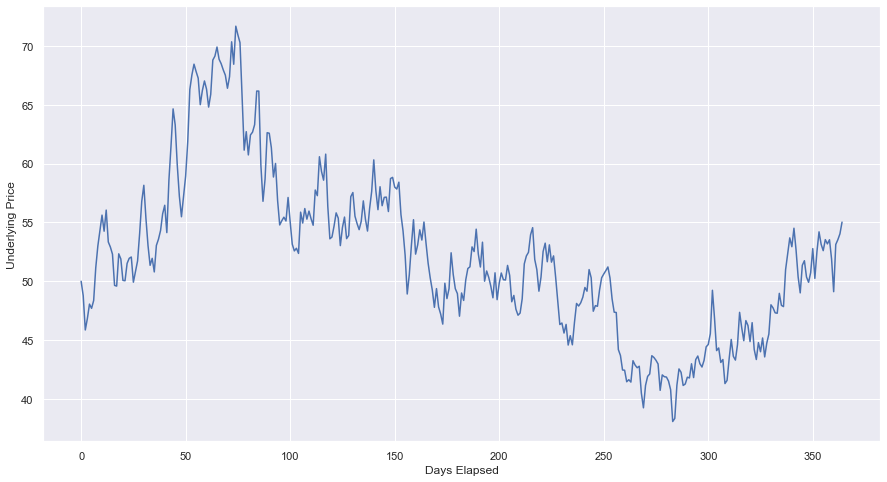

In [253]:
plt.figure(figsize=(15,8))
sample = pd.DataFrame(sample,columns=['Underlying Price'])
plt.xlabel('Days Elapsed')
plt.ylabel('Underlying Price')
plt.plot(sample)
plt.show()

Let's come up with a trading strategy that buys or sells the underlying according to a delta hedge determined first by time, then we will try adjusting after the underlying has moved by a certain percentage amount.

In [274]:
sample['weekly_adjust_signal'] = (sample.index % 7 == 0).astype(int)

In [275]:
signal = sample[sample['weekly_adjust_signal'] == 1]

In [276]:
signal['Option Price'] = [BSM(option_type, row['Underlying Price'], K, r, sigma, (365-idx)/365) for idx,row in signal.iterrows()]
signal['Delta'] = [delta(option_type, row['Underlying Price'], K, r, sigma, (365-idx)/365) for idx,row in signal.iterrows()]
signal['Position'] = -1*signal['Delta']
signal['Change in Underlying Position'] = signal['Position'].diff().fillna(0)
signal['Change in Underlying Price'] = signal['Underlying Price'].diff().fillna(0)

# -1 Since we are short
signal['Option P&L'] = signal['Option Price'].diff()
signal['Underlying P&L'] = signal['Change in Underlying Price'] * -1 * signal['Delta']

In [277]:
signal['Underlying P&L'].sum()

-9.747008620150288

In [278]:
signal['Option P&L'].sum()

-8.722831374787546

In [279]:
unrealized_pnl = []
realized_pnl = []
average_entry_price = []

current_position = signal['Position'][0]
current_average_entry_price = signal['Underlying Price'][0]
cumulative_realized_pnl = 0.0

for index, row in signal.iterrows():
    change_in_position = row['Position'] - current_position
    price = row['Underlying Price']
    
    if change_in_position != 0:
        
        # Increasing or opening a position
        if change_in_position * current_position >= 0:  
            
            # Calculate new average entry price
            if current_position == 0:
                current_average_entry_price = price
            else:
                current_average_entry_price = (current_average_entry_price * current_position + price * change_in_position) / row['Position']                                                                                                                      
            realized_pnl.append(cumulative_realized_pnl)
            
        # Reducing or closing a position    
        else:  
            
            # Calculate realized PnL
            # Closing or flipping
            if abs(change_in_position) >= abs(current_position):  
                current_realized_pnl = (price - current_average_entry_price) * current_position
                current_average_entry_price = price if change_in_position + current_position != 0 else 0
                
            # Partially closing
            else:  
                current_realized_pnl = (price - current_average_entry_price) * change_in_position
            
            cumulative_realized_pnl += current_realized_pnl
            realized_pnl.append(cumulative_realized_pnl)
        
        # Update current position
        current_position = row['Position']
        
    else:
        realized_pnl.append(cumulative_realized_pnl)
        
    # Calculate unrealized PnL
    current_unrealized_pnl = (price - current_average_entry_price) * current_position
    unrealized_pnl.append(current_unrealized_pnl)
    average_entry_price.append(current_average_entry_price)
    

In [280]:
signal['Realized P&L'] = realized_pnl
signal['Unrealized P&L'] = unrealized_pnl
signal['Average Entry Price'] = average_entry_price
signal['Total P&L'] = signal['Realized P&L'] + signal['Unrealized P&L']

In [281]:
signal

,Underlying Price,weekly_adjust_signal,Option Price,Delta,Position,Change in Underlying Position,Change in Underlying Price,Option P&L,Underlying P&L,Realized P&L,Unrealized P&L,Average Entry Price,Total P&L
0,50.000000,1,13.760013,0.679631,-0.679631,0.000000,0.000000,NaN,-0.000000,0.000000,-0.000000,50.000000,0.000000
7,51.143563,1,14.400785,0.691542,-0.691542,-0.011911,1.143563,0.640772,-0.790822,0.000000,-0.777201,50.019697,-0.777201
14,52.902719,1,15.486999,0.710053,-0.710053,-0.018511,1.759156,1.086214,-1.249094,0.000000,-1.993731,50.094857,-1.993731
21,50.041063,1,13.356517,0.675248,-0.675248,0.034805,-2.861656,-2.130482,1.932329,-0.001872,0.036324,50.094857,0.034452
28,54.067173,1,16.018395,0.720409,-0.720409,-0.045161,4.026110,2.661878,-2.900446,-0.001872,-2.682300,50.343871,-2.684173
35,50.791999,1,13.569911,0.681278,-0.681278,0.039131,-3.275174,-2.448484,2.231304,0.015663,-0.305299,50.343871,-0.289636
42,58.595952,1,19.069449,0.764258,-0.764258,-0.082980,7.803954,5.499538,-5.964234,0.015663,-5.621962,51.239848,-5.606298
49,57.167095,1,17.827544,0.749895,-0.749895,0.014363,-1.428858,-1.241905,1.071493,0.100797,-4.444812,51.239848,-4.344016
56,67.261833,1,25.681434,0.833125,-0.833125,-0.083230,10.094738,7.853890,-8.410175,0.100797,-12.014805,52.840454,-11.914009
63,68.798472,1,26.805908,0.843578,-0.843578,-0.010454,1.536640,1.124474,-1.296276,0.100797,-13.295018,53.038209,-13.194221


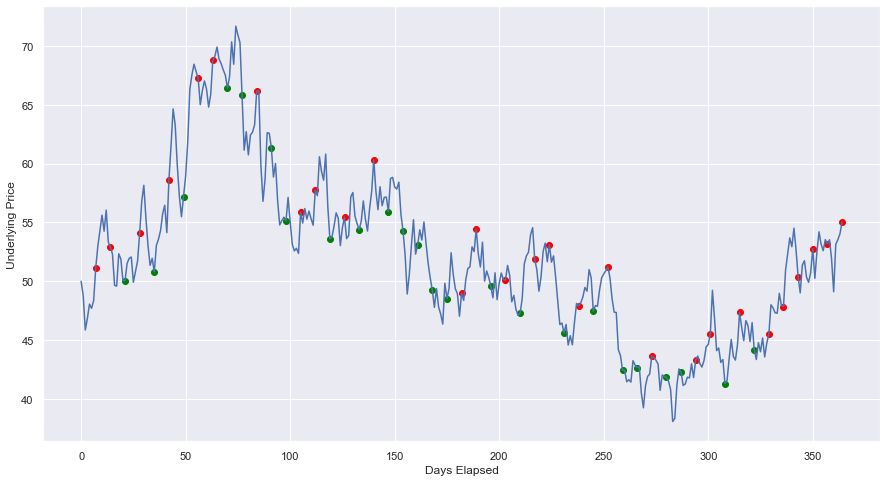

In [282]:
plt.figure(figsize=(15,8))
sample = pd.DataFrame(sample,columns=['Underlying Price'])
plt.xlabel('Days Elapsed')
plt.ylabel('Underlying Price')
plt.plot(sample)
buys = signal[signal['Change in Underlying Position'] > 0]
sells = signal[signal['Change in Underlying Position'] < 0]
plt.scatter(buys.index, buys['Underlying Price'], color='green', label='Buy Signal')
plt.scatter(sells.index, sells['Underlying Price'], color='red', label='Sell Signal')
plt.show()

<AxesSubplot:>

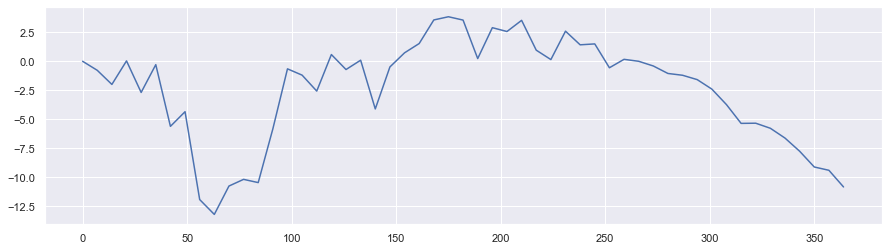

In [289]:
signal['Total P&L'].plot(figsize=(15,4))

Unfortunately, this outcome was not profitable. Let's see if tweaking the options/underlying parameters makes a difference:

In [325]:
S=50
K=50
sigma=0.6
mu=1
t=1
N=365
dt=t/N


def calculate_strategy_pnl(S, K, mu, sigma, t, N, dt):
    sample = geometric_brownian_motion(S, mu, sigma, t, N, dt)
    sample = np.insert(sample, 0, 50)[:-2]
    sample = pd.DataFrame(sample,columns=['Underlying Price'])
    sample['weekly_adjust_signal'] = (sample.index % 7 == 0).astype(int)

    signal = sample[sample['weekly_adjust_signal'] == 1]

    signal['Option Price'] = [BSM(option_type, row['Underlying Price'], K, r, sigma, (365-idx)/365) for idx,row in signal.iterrows()]
    signal['Delta'] = [delta(option_type, row['Underlying Price'], K, r, sigma, (365-idx)/365) for idx,row in signal.iterrows()]
    signal['Position'] = -1*signal['Delta']
    signal['Change in Underlying Position'] = signal['Position'].diff().fillna(0)
    signal['Change in Underlying Price'] = signal['Underlying Price'].diff().fillna(0)

    # -1 Since we are short
    signal['Option P&L'] = signal['Option Price'].diff()
    signal['Underlying P&L'] = signal['Change in Underlying Price'] * -1 * signal['Delta']

    unrealized_pnl = []
    realized_pnl = []
    average_entry_price = []

    current_position = signal['Position'][0]
    current_average_entry_price = signal['Underlying Price'][0]
    cumulative_realized_pnl = 0.0

    for index, row in signal.iterrows():
        change_in_position = row['Position'] - current_position
        price = row['Underlying Price']

        if change_in_position != 0:

            # Increasing or opening a position
            if change_in_position * current_position >= 0:  

                # Calculate new average entry price
                if current_position == 0:
                    current_average_entry_price = price
                else:
                    current_average_entry_price = (current_average_entry_price * current_position + price * change_in_position) / row['Position']                                                                                                                      
                realized_pnl.append(cumulative_realized_pnl)

            # Reducing or closing a position    
            else:  

                # Calculate realized PnL
                # Closing or flipping
                if abs(change_in_position) >= abs(current_position):  
                    current_realized_pnl = (price - current_average_entry_price) * current_position
                    current_average_entry_price = price if change_in_position + current_position != 0 else 0

                # Partially closing
                else:  
                    current_realized_pnl = (price - current_average_entry_price) * change_in_position

                cumulative_realized_pnl += current_realized_pnl
                realized_pnl.append(cumulative_realized_pnl)

            # Update current position
            current_position = row['Position']

        else:
            realized_pnl.append(cumulative_realized_pnl)

        # Calculate unrealized PnL
        current_unrealized_pnl = (price - current_average_entry_price) * current_position
        unrealized_pnl.append(current_unrealized_pnl)
        average_entry_price.append(current_average_entry_price)

    signal['Realized P&L'] = realized_pnl
    signal['Unrealized P&L'] = unrealized_pnl
    signal['Average Entry Price'] = average_entry_price
    signal['Total P&L'] = signal['Realized P&L'] + signal['Unrealized P&L']
    
    #print(f"trading p&l: {signal['Total P&L'].iloc[-1]} option p&l: {(max(signal['Underlying Price'].iloc[0]-K,0) - signal['Option Price'].iloc[0])}")

    return signal['Total P&L'].iloc[-1] + (max(signal['Underlying Price'].iloc[-1]-K,0) - signal['Option Price'].iloc[0])

In [328]:
rng = np.random.default_rng(101)

S=50
K=50
sigma=0.2
mu=1
t=1
N=365
dt=t/N

pnl_list = []
for i in range(1000):
    pnl_list.append(calculate_strategy_pnl(S, K, mu, sigma, t, N, dt))

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   1.,   1.,
          0.,   0.,   0.,   0.,   3.,   4.,   8.,  26., 955.]),
 array([-1.90326643, -1.90326567, -1.90326492, -1.90326416, -1.9032634 ,
        -1.90326265, -1.90326189, -1.90326113, -1.90326038, -1.90325962,
        -1.90325887, -1.90325811, -1.90325735, -1.9032566 , -1.90325584,
        -1.90325508, -1.90325433, -1.90325357, -1.90325282, -1.90325206,
        -1.9032513 ]),
 <BarContainer object of 20 artists>)

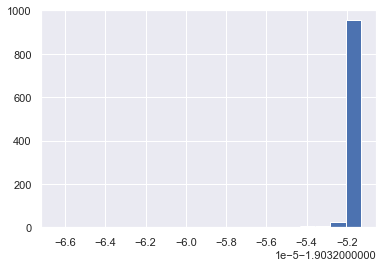

In [329]:
#plt.hist(pnl_list, bins=20)